## Gather Data

In [1]:
import re
import pandas as pd
import tweepy
import json
import time
import numpy as np
import requests

In [121]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [4]:
CONSUMER_KEY = 'XXXXXXXXXX'
CONSUMER_SECRET = 'XXXXXXXXXX'
ACCESS_TOKEN = 'XXXXXXXXXX'
ACCESS_SECRET = 'XXXXXXXXXX'
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [250]:
df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            # filter out keep-alive new chunks
            if chunk:
                f.write(chunk)
    return local_filename

In [6]:
download_file(URL)

'image-predictions.tsv'

In [7]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

In [8]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [9]:
start_time = time.time()
# for tweet_id in ids_of_tweet:
for tweet_id in df.tweet_id:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        data = tweet._json
        with open('tweet_json.txt', 'a') as outfile:
            json.dump(data, outfile)
            __ = outfile.write('\n')
    except Exception:
        print('tweet: {} deleted.'.format(tweet_id))

print('took time %s seconds' % (time.time() - start_time))

tweet: 888202515573088257 deleted.
tweet: 873697596434513921 deleted.
tweet: 872668790621863937 deleted.
tweet: 869988702071779329 deleted.
tweet: 866816280283807744 deleted.
tweet: 861769973181624320 deleted.
tweet: 845459076796616705 deleted.
tweet: 842892208864923648 deleted.
tweet: 837012587749474308 deleted.
tweet: 827228250799742977 deleted.
tweet: 812747805718642688 deleted.
tweet: 802247111496568832 deleted.
tweet: 775096608509886464 deleted.
tweet: 770743923962707968 deleted.
Rate limit reached. Sleeping for: 736
tweet: 754011816964026368 deleted.
tweet: 680055455951884288 deleted.
Rate limit reached. Sleeping for: 735
took time 1912.314391374588 seconds


In [251]:
tweet_df = pd.DataFrame()
with open('tweet_json.txt') as json_file:
    for line in json_file:
        data = json.loads(line.rstrip())
        tmp_df = pd.DataFrame.from_dict(data, orient='index').T
        tweet_df = tweet_df.append(tmp_df, ignore_index=True)

In [252]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2342 non-null object
display_text_range               2342 non-null object
entities                         2342 non-null object
extended_entities                2068 non-null object
favorite_count                   2342 non-null object
favorited                        2342 non-null object
full_text                        2342 non-null object
geo                              0 non-null object
id                               2342 non-null object
id_str                           2342 non-null object
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null object
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null object
in_reply_to_user_id_str          77 non-null o

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

## Asses for Quality and Tidiness

### Quality
> twitter-archive-enhanced.csv
    1. timestamp of object type
    2. names 'the', 'an' and 'a' (maybe looking from "This is" in name and assumed 3rd index is name)
    3. doggo floofer pupper puppo None not pandas NULL or NA
    4. some ratings are off df.text[313]
    5. different rating scale df.text[1634] 143/130 (NO NEED)
    5. correct rating num and deno df.loc[516, 'rating_numerator'] = np.nan
    6. convert in_reply_to_status_id and in_reply_to_user_id to int64 (NO NEED)
    7. multiple entries in expanded urls df.expanded_urls[150]
    8. Convert None name to pandas None (NO NEED)

> tweet_json.txt
    9. 14 tweets got deleted. so missing data
    10. column favorite_count should be int
    11. column retweet_count should be int
    12. convert column created_at to datetime (NO-NEED)
    13. correct rating num with decimal values
    14. get dog pic url.

### Tidiness

> twitter-archive-enhanced.csv
    1. column doggo floofer pupper puppo should be one "breed" column
    2. take id_str out
    3. delete user, full_text column
    4. convert display_text_range to length column
    5. create new tweet table with columns tweet_id, timestamp/created_at, source/source, text/full_text, expanded_urls, rating_numerator, rating_denominator, display_text_range/length, favorite_count, is_quote_status, lang, retweet_count
    6. new column rating_ratio
    7. Create new table dog with tweet_id name type(doggo floofer pupper puppo), pic_url, pic_media_id

## Clean Data

In [254]:
df.timestamp = pd.to_datetime(df.timestamp)

In [255]:
df.loc[df.name == 'None', 'name'] = np.nan
df.loc[df.name == 'a', 'name'] = np.nan
df.loc[df.name == 'an', 'name'] = np.nan
df.loc[df.name == 'the', 'name'] = np.nan
df.loc[df.name == 'quite', 'name'] = np.nan
df.loc[df.name == 'very', 'name'] = np.nan

In [256]:
def get_type(one_row):
    ret_str = ','.join([x for x in one_row.split(',') if x != "None"])
    if ret_str:
        return ','.join([x for x in one_row.split(',') if x != "None"])
    else:
        return np.nan

In [257]:
# Tidiness
# 1.
df['type'] = df.doggo + ',' + df.floofer + ',' + df.pupper + ',' + df.puppo

In [258]:
# 3
df['type'] = df['type'].apply(get_type)

In [259]:
# 4.
df.loc[313, 'rating_numerator'] = 13
df.loc[313, 'rating_denominator'] = 10

In [260]:
# T6.
df['rating_ratio'] = df.rating_numerator / df.rating_denominator

In [261]:
# 5.
df.loc[516, 'rating_numerator'] = np.nan
df.loc[516, 'rating_denominator'] = np.nan
df.loc[516, 'rating_ratio'] = np.nan

In [262]:
def find_numerator(one_row):
    res_out = re.search(r'\d+\.\d+/\d+', one_row)
    if res_out:
        return float(res_out.group(0).split('/')[0])
    elif re.search(r'\d+/\d+', one_row):
        res_out = re.findall(r'\d+/\d+', one_row)
        if len(res_out) > 1:
            return float(res_out[-1].split('/')[0])
        else:
            return float(res_out[0].split('/')[0])

In [263]:
def find_denominator(one_row):
    res_out = re.search(r'\d+\.\d+/\d+', one_row)
    if res_out:
        return float(res_out.group(0).split('/')[1])
    elif re.search(r'\d+/\d+', one_row):
        res_out = re.findall(r'\d+/\d+', one_row)
        if len(res_out) > 1:
            return float(res_out[-1].split('/')[1])
        else:
            return float(res_out[0].split('/')[1])

In [264]:
# 13
df['rating_numerator_new'] = df.text.apply(find_numerator)
df['rating_denominator_new'] = df.text.apply(find_denominator)

In [265]:
df[df.text.str.contains('This is an Albanian 3 1/2 legged  Episcopalian')][['rating_numerator','rating_numerator_new','rating_denominator','rating_denominator_new']]

,rating_numerator,rating_numerator_new,rating_denominator,rating_denominator_new
2335,1.0,9.0,2.0,10.0


In [266]:
df['rating_ratio'] = df.rating_numerator_new / df.rating_denominator_new

In [267]:
df.loc[516, 'rating_numerator_new'] = np.nan
df.loc[516, 'rating_denominator_new'] = np.nan
df.loc[516, 'rating_ratio'] = np.nan

In [268]:
def get_dog_pic_url(one_row):
    if 'media' in one_row:
        return one_row['media'][0]['media_url_https']
    else:
        return np.nan

In [269]:
def get_dog_media_id(one_row):
    if 'media' in one_row:
        return one_row["media"][0]["id"]
    else:
        return np.nan

In [270]:
# 7.
def get_expanded_urls(one_row):
    if type(one_row) is str:
        return one_row.split(',')[-1]
    else:
        return np.nan

In [271]:
df['expanded_urls_new'] = df.expanded_urls.apply(get_expanded_urls)

In [272]:
# 10.
tweet_df.favorite_count = tweet_df.favorite_count.astype(int)

In [273]:
# 11.
tweet_df.retweet_count = tweet_df.retweet_count.astype(int)

In [274]:
def get_length(one_row):
    one_row_list = list(one_row)
    return int(one_row_list[1] - one_row_list[0])

In [275]:
# 4
tweet_df['display_text_length'] = tweet_df.display_text_range.apply(get_length)

In [276]:
df2 = tweet_df.copy()

In [277]:
df3 = pd.merge(df2, df, how='left', left_on='id', right_on='tweet_id')

In [278]:
tweet = df3.copy()

In [279]:
dog = df3.copy()

In [280]:
dog["dog_pic_url"] = dog.entities.apply(get_dog_pic_url)

In [281]:
dog["dog_media_id"] = dog.entities.apply(get_dog_media_id)

In [282]:
tweet.drop(['contributors', 'coordinates'], axis=1, inplace=True)

In [283]:
tweet.drop(['expanded_urls', 'created_at', 'display_text_range', 'entities', 'extended_entities', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id_x', 'in_reply_to_status_id_str', 'in_reply_to_user_id_x', 'in_reply_to_user_id_str', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'retweeted', 'retweeted_status', 'truncated', 'user', 'in_reply_to_status_id_y', 'in_reply_to_user_id_y', 'source_y', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 'type'], axis=1, inplace=True)

In [284]:
dog.drop(['contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id_x', 'in_reply_to_status_id_str', 'in_reply_to_user_id_x', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'retweet_count', 'retweeted', 'retweeted_status', 'source_x', 'truncated', 'user', 'display_text_length', 'in_reply_to_status_id_y', 'in_reply_to_user_id_y', 'timestamp', 'source_y', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo', 'rating_ratio', 'rating_numerator_new', 'rating_denominator_new', 'expanded_urls_new'], axis=1, inplace=True)

In [285]:
dog.rename(index=str, columns={"dog_pic_url": "pic_url", "dog_media_id": "media_id"}, inplace=True)

In [286]:
tweet.rename(index=str, columns={"source_x": "source", "rating_numerator_new": "rating_numerator", "rating_denominator_new": "rating_denominator", "expanded_urls_new": "expanded_urls"}, inplace=True)

In [287]:
dog.head()

,tweet_id,name,type,pic_url,media_id
0,892420643555336193,Phineas,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,8.924206e+17
1,892177421306343426,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,8.921774e+17
2,891815181378084864,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,8.918152e+17
3,891689557279858688,Darla,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,8.916896e+17
4,891327558926688256,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,8.913276e+17


In [288]:
tweet.head()

,favorite_count,is_quote_status,lang,retweet_count,source,display_text_length,tweet_id,timestamp,text,rating_ratio,rating_numerator,rating_denominator,expanded_urls
0,38125,False,en,8337,"<a href=""http://twitter.com/download/iphone"" r...",85,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,1.3,13.0,10.0,https://twitter.com/dog_rates/status/892420643...
1,32700,False,en,6162,"<a href=""http://twitter.com/download/iphone"" r...",138,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,1.3,13.0,10.0,https://twitter.com/dog_rates/status/892177421...
2,24623,False,en,4079,"<a href=""http://twitter.com/download/iphone"" r...",121,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,1.2,12.0,10.0,https://twitter.com/dog_rates/status/891815181...
3,41474,False,en,8483,"<a href=""http://twitter.com/download/iphone"" r...",79,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,1.3,13.0,10.0,https://twitter.com/dog_rates/status/891689557...
4,39636,False,en,9169,"<a href=""http://twitter.com/download/iphone"" r...",138,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,1.2,12.0,10.0,https://twitter.com/dog_rates/status/891327558...


## Storing, Analyzing, and Visualizing Data for this Project

In [289]:
tweet.to_csv('tweet.csv')

In [290]:
dog.to_csv('dog.csv')

In [291]:
from sqlalchemy import create_engine

In [292]:
engine = create_engine('sqlite:///wrangle_act.db')

In [293]:
tweet.to_sql('tweet', con=engine)

In [294]:
dog.to_sql('dog', con=engine)

In [295]:
base_color = sb.color_palette()[0]

### Most popular dog names.

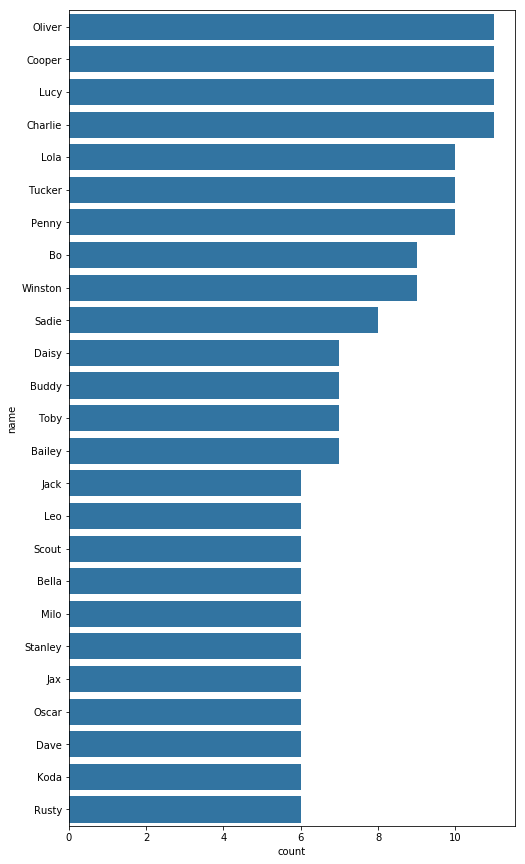

In [296]:
plt.figure(figsize=(8, 15))
sb.countplot(y='name', color=base_color, data=dog, order=dog.name.value_counts().iloc[:25].index);

### Most Favorite Dog Ttype

In [310]:
dog[dog.tweet_id == tweet[tweet.favorite_count == tweet.favorite_count.max()].tweet_id[0]].type[0]

'doggo'

### Dogs Rating Ratio Distribution

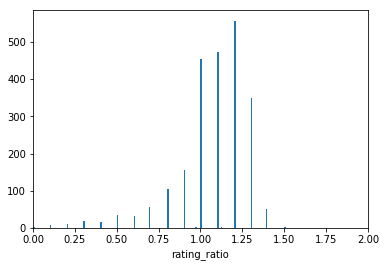

In [332]:
bin_edges = np.arange(0, tweet.rating_ratio.max()+0.01, 0.01)
sb.distplot(tweet[tweet.rating_ratio.notnull()].rating_ratio, bins=bin_edges, kde=False, hist_kws={'alpha': 1});
plt.xlim(0, 2);

### Most High Rated Dog Name and Rating Text

In [335]:
tweet[tweet.rating_ratio == tweet.rating_ratio.max()].text[0]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [338]:
dog[dog.tweet_id == tweet[tweet.rating_ratio == tweet.rating_ratio.max()].tweet_id[0]].name[0]

'Atticus'